**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

## Notes

### Character encode error

In [17]:
trn,trn_y = texts_labels_from_folders(f'{PATH}aclImdb/train',names)
val,val_y = texts_labels_from_folders(f'{PATH}aclImdb/test',names)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 194: character maps to <undefined>

If you encount the error above then go into text.py and change `texts.append(open(fname, 'r').read())` to `texts.append(open(fname, 'r',encoding='utf-8').read())`

### Fit Error

In [10]:
learner = md.dotprod_nb_learner()
learner.fit(0.02, 1, wds=1e-6, cycle_len=1)

epoch      trn_loss   val_loss   <lambda>                                      


AttributeError: 'float' object has no attribute 'rint'

The error above arises from the fact that we are rounding the numbers to float, while printing the stats. Here is a [solution](https://forums.fast.ai/t/unfamiliar-error-when-running-learn-fit/35075/20).<br> 
Change line *184* and *189* in **model.py** from `list(np.round(values, decimals))` to `list(values)`.

### dotprod_nb_learner() demystified

#### Regularisation with Naive Bayes

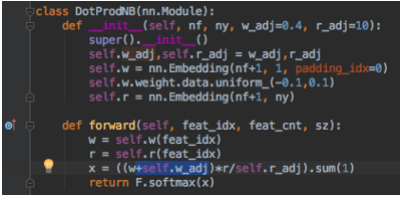 <br>

The thing I’m adding is, it’s a parameter, but I pretty much always use this default value 0.4. So what does this do? What this is doing is it’s again changing the prior. If you think about it, even once we used this *"r"* times the term document matrix as their independent variables, you really want to start with a question, okay, the penalty terms are still pushing `w` down to zero. **0 means absence of Naive Bayes coefficient and 1 means that the Naive Bayes coefficients are correct**. But we don't want either of these extremes. So empirically it's set to **0.4**. This makes sure that we are pushing all the weights towards **0.4** and not **"0"**. <br>
**Regularisation with w_adj & r_adj** <br>
If the value of the penalty term is zero, then there is no regularization. But if this value is higher than zero, then there is some penalty. And presumably, we’ve set it to nonzero because we were overfitting. So we want some penalty. So if there is some penalty, ***then my assertion is that we should penalize things that are different to our prior, not that we should penalize things that are different to zero. And our prior is that things should be around about equal to r***. There is also another parameter **(r_adj=10)** as well which is the same thing I do to **"r"** is actually divide by a parameter, which can be used to adjust what the nature of the regularization is.<br>

#### Embedding

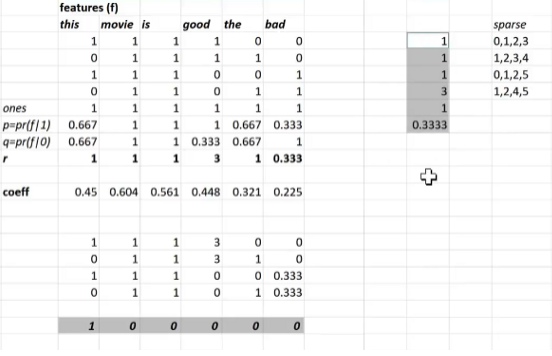 <br>
The **bag of words** matrix is one hot encoded matrix. But we have a **sparse matrix** that's stored and we would like to do the same matrix multiplication with the sparse matrix instead of the bag of words matrix. <br>
If we took the simple version of does it have a word “this” (i.e. 1, 0, 0, 0, 0, 0) and we multiplied that by r, then it’s just going to return the first item.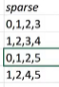. If i were to find the matrix product of my highlighted sparse matrix and **"r"** then it's the same as picking up the the 0th, first, second, and fifth coefficients(r). Refer to the picture below. Here we have R negative and postive for representing multinomial cases. 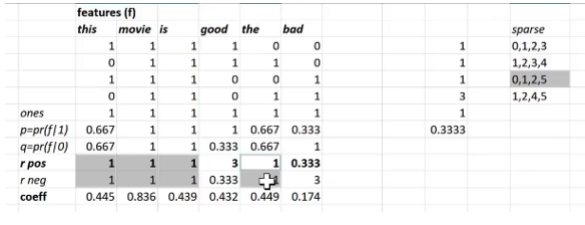<br>
**Definition**<br>
The computational trick of multiplying a sparse matrix with the coefficients yields to picking up the nth row/item in the coefficient matrix/vector. So this computational trick which is mathematically identical to, not conceptually analogous to, multiplying by one hot encoded matrix is called an **embedding**. **Embedding means make a multiplication by a one hot encoded matrix faster by replacing it with a simple array lookup.**

### Categorical Variables vs Continuous Variables

Whenever possible it's better to pass into a neural net categorical variables as it asks the neural net to create a function which best matches the difference of a categorical variable instead of a continuous one. For eg. if we have a grocery store competition and there is a variable called `Competitionopensince` (date when the competition opened their store nearby our store in month format), it's always better to treat this as a categorical variable as it makes a lot of difference whether the competition opened their store before 2 months or after 2 months of your store opening. If it were considered as a continuous variable then it would not have the same functional form in the neural net and this importance would be missed. 

## IMDB dataset and the sentiment classification task

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

To get the dataset, in your terminal run the following commands:

`wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz`

`gunzip aclImdb_v1.tar.gz`

`tar -xvf aclImdb_v1.tar`

### Tokenizing and term document matrix creation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.nlp import *
from fastai.io import *
from sklearn.linear_model import LogisticRegression

In [2]:
PATH='E:/Fastai/Data/IMDB/'
names = ['neg','pos']

In [8]:
URL='http://ai.stanford.edu/~amaas/data/sentiment/'
FILENAME='aclImdb_v1.tar.gz'
get_data(URL+FILENAME, PATH+FILENAME)

aclImdb_v1.tar.gz: 84.1MB [02:09, 648kB/s]                                     


In [12]:
%ls {PATH}

Invalid switch - "Fastai".


In [ ]:
%ls {PATH}train

aclImdb/  all_val/         neg/  tmp/    unsupBow.feat  urls_pos.txt
all/      labeledBow.feat  pos/  unsup/  urls_neg.txt   urls_unsup.txt


In [ ]:
%ls {PATH}train/pos | head

0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt
ls: write error


In [3]:
trn,trn_y = texts_labels_from_folders(f'{PATH}aclImdb/train',names)
val,val_y = texts_labels_from_folders(f'{PATH}aclImdb/test',names)

Here is the text of the first review

In [7]:
trn[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [8]:
trn_y[0]

0

[`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts (part of `sklearn.feature_extraction.text`). This creates a **term document matrix**. 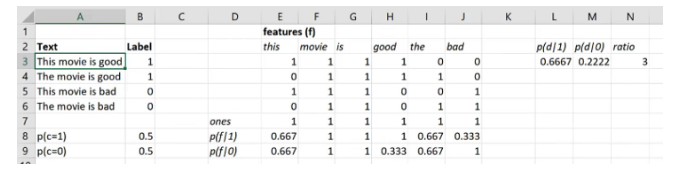<br> `tokenize` is a fastai specific **tokeniser**, which uses the basic concept of splitting any sentence into a *bag of words (individual words)* in order to create a **term document matrix**. 

In [6]:
veczr = CountVectorizer(tokenizer=tokenize)

`fit_transform(trn)` finds the vocabulary in the training set. It also transforms the training set into a term-document matrix. Since we have to apply the *same transformation* to your validation set, the second line uses just the method `transform(val)`. `trn_term_doc` and `val_term_doc` are **sparse matrices**. `trn_term_doc[i]` represents training document i and it contains a count of words for each document for each word in the vocabulary. <br> If in the validation set we have some words, which didn't occur in the training set then it would be considered as unknown by the frequency of the word i.e. if the word appears 3 times or more then please mark it unknown otherwise ignore. 

In [7]:
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

In [17]:
trn_term_doc

<25000x75132 sparse matrix of type '<class 'numpy.int64'>'
	with 3749745 stored elements in Compressed Sparse Row format>

By storing it as a **sparse matrix** we are just keeping the relevant words for each review. So you will notice, from the 75132 unique words that are stored in the entire training dataset we are just having 93 unique words, which are needed for the first review. This is arrived by just storing the relevant indices. In this way we just store the relevant set of unique words and not store the entire set of unique words for each review. 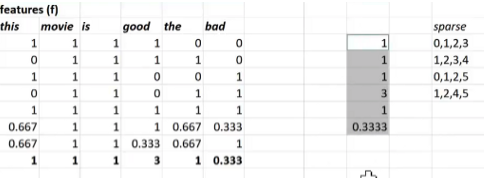

In [18]:
trn_term_doc[0]

<1x75132 sparse matrix of type '<class 'numpy.int64'>'
	with 93 stored elements in Compressed Sparse Row format>

In [ ]:
vocab = veczr.get_feature_names(); vocab[5000:5005] # the number returns the corresponding word in the array

['aussie', 'aussies', 'austen', 'austeniana', 'austens']

In [ ]:
w0 = set([o.lower() for o in trn[0].split(' ')]); w0

{'a',
 'absurd',
 'an',
 'and',
 'audience',
 'be',
 'better',
 'briefly.',
 'by',
 'can',
 'chantings',
 'cinematography',
 'comedy.',
 'crazy',
 'cryptic',
 'dialogue',
 'easy',
 'era',
 'even',
 'eventually',
 'example',
 'feelings',
 'for',
 'formal',
 'forrest',
 'frederic',
 'from',
 'future',
 'general',
 'good',
 'grader.',
 'great',
 'has',
 'insane,',
 'into',
 'is',
 'it',
 "it's",
 'just',
 'kirkland',
 'level',
 'make',
 'making',
 'man',
 'might',
 'mob',
 'narrative',
 'no',
 'of',
 'off',
 'off.',
 'on',
 'opening',
 'orchestra',
 'out',
 'pig.',
 'putting.',
 'sally',
 'scene',
 'seem',
 'seen',
 'shakespeare',
 'should',
 'singers.',
 'some',
 'stars',
 'starts',
 'stays',
 'story',
 'technical',
 'terrific',
 'than',
 'that',
 'the',
 'think',
 'third',
 'those',
 'time',
 'to',
 'too',
 'turned',
 'unfortunately',
 'unnatural',
 'vilmos',
 'violent',
 'who',
 'whole',
 'with',
 'would',
 'you',
 'zsigmond.'}

In [ ]:
len(w0)

91

In [ ]:
veczr.vocabulary_['absurd'] # the word returns the corresponding position in the array

1297

In [ ]:
trn_term_doc[0,1297] #this returns the frequency of the word in the first review

2

In [ ]:
trn_term_doc[0,5000]

0

## Naive Bayes

We define the **log-count ratio** $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents.<br><br> 
Let's take an example for this case: For `y==0` `p = x[y==y_i].sum(0) ` we are taking all the sum of the rows of x, where `y==0` and then adding *1* to it as we would want to account for the probability of the word not appearing as $\text{p} \neq{0}$, if not when a word is absent then the probability is *0* which isn't the case. Therefore, we need to add *1* so that we can account for the correct probability for the presence of the word. `(p+1) / ((y==y_i).sum()+1)` We divide *p+1* with the *# of documents where y==0* to find the *ratio of feature f in negative documents*. The same is done to find the *ratio of feature f in the positive document*. Then we take the log of the ratio *r* instead of multiplying as, if you multiply enough of the probabilities we would get a number very close to 0 and one would run out of floating point. We have to multiply logically each one of the word probabilities appearing in either the positive or negative document to find the probability $\text{p(d|1) or p(d|0)}$ 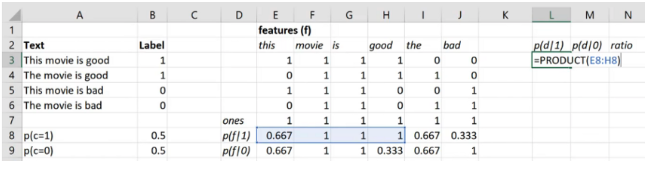 as bayes rule says 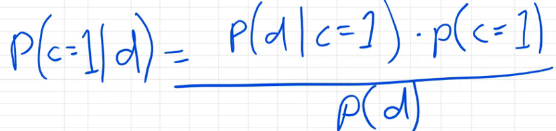 p(f|1)=p, and p(f|0)=q <br> 
where we are calculating 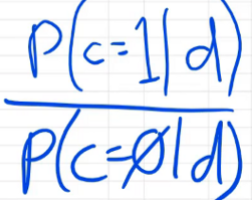. For the above equation **if the number is > 1 then it's more likely to be class 1 and vice versa**. We are adding *"b"*,the ratio of the whole class probabilities i.e. $\frac{\text{p(c==1)}}{\text{p(c==0)}}$, to the ratio *"r"*. <br> 

We are trying to find the whether the document is positive or negative, which translates to 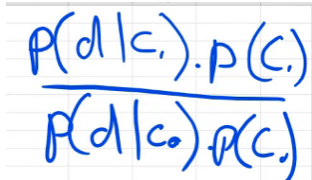, so $\text{p(d|1)}$ is to multiply all the probabilities($\text{p(f|1)}$) of the features appearing in a positive document and for $\text{p(d|0)}$it's the multiplication of all the probabilties($\text{p(f|0)}$) of the features appearing in a negative document. $\text{p(c == 1)} = \text{mean(c == 1)}$. Once we have the *final ratio* 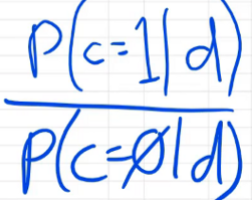 we can predict whether the document is having a positive or negative sentiment. But in python we do the following `val_term_doc @ r.T + b` and then consider whether it's > 0 or < 0 as we are in log space and can't consider > 1 or < 1 and test the accuracy by `(preds==val_y).mean()`. 

In [14]:
def pr(y_i):
    p = x[y==y_i].sum(0) 
    return (p+1) / ((y==y_i).sum()+1)

In [19]:
x=trn_term_doc
y=trn_y

r = np.log(pr(1)/pr(0))
b = np.log((y==1).mean() / (y==0).mean())

Here is the formula for **Naive Bayes**.

In [28]:
pre_preds = val_term_doc @ r.T + b # multiplying the term_doc by log of ratio of the feature appearing in the postive 
# as well as the negative documents and adding the original ratio of class 1 to class 0
preds = pre_preds.T>0
(preds==val_y).mean()

0.81656

...and **binarized Naive Bayes**. The difference is that we don't account for the frequency of the words like the earlier method but turn everything into binary by taking anything positive as 1 and anything negative as -1 irrespective of the frequency of the word. 

In [29]:
x=trn_term_doc.sign()
r = np.log(pr(1)/pr(0))

pre_preds = val_term_doc.sign() @ r.T + b
preds = pre_preds.T>0
(preds==val_y).mean()

0.83016

### Logistic regression

Here is how we can fit logistic regression where the features are the **unigrams**.**Unigrams** gives you single unique words but **bigrams** and **trigrams** give you two words and three words next to each other respectively.

In [ ]:
m = LogisticRegression(C=1e8, dual=True) # put dual=True when the matrix is wider than it's taller, it will compute faster
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.85504000000000002

In [ ]:
m = LogisticRegression(C=1e8, dual=True)
m.fit(trn_term_doc.sign(), y)
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.85487999999999997

...and the regularized version

In [ ]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.88275999999999999

In [ ]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(trn_term_doc.sign(), y)
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.88404000000000005

### Trigram with NB features

Our next model is a version of logistic regression with Naive Bayes features described [here](https://www.aclweb.org/anthology/P12-2018). For every document we compute binarized features as described above, but this time we use bigrams and trigrams too. Each feature is a log-count ratio. A logistic regression model is then trained to predict sentiment.

In [30]:
veczr =  CountVectorizer(ngram_range=(1,3), tokenizer=tokenize, max_features=800000)
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

In [ ]:
trn_term_doc.shape

(25000, 800000)

In [ ]:
vocab = veczr.get_feature_names()

In [ ]:
vocab[200000:200005]

['by vast', 'by vengeance', 'by vengeance .', 'by vera', 'by vera miles']

In [31]:
y=trn_y
x=trn_term_doc.sign()
val_x = val_term_doc.sign()

In [32]:
r = np.log(pr(1) / pr(0))
b = np.log((y==1).mean() / (y==0).mean())

Here we fit regularized logistic regression where the features are the trigrams.

In [33]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(x, y);

preds = m.predict(val_x)
(preds.T==val_y).mean()

e:\Anaconda\envs\fastai-cpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.905

Here is the $\text{log-count ratio}$ `r`.  

In [34]:
r.shape, r

((1, 800000),
 matrix([[-0.05468, -0.161  , -0.24784, ...,  1.09861, -0.69315, -0.69315]]))

We need to take the exp to see whether the word is negative/positive(>1 is positive and <1 is negative)

In [35]:
np.exp(r)

matrix([[0.94678, 0.85129, 0.78049, ..., 3.     , 0.5    , 0.5    ]])

Here we fit regularized logistic regression where the features are the trigrams' log-count ratios.<br><br> 
The difference in the code below is: we are multiplying the **term document matrix(x)** by **"r"** effectively.
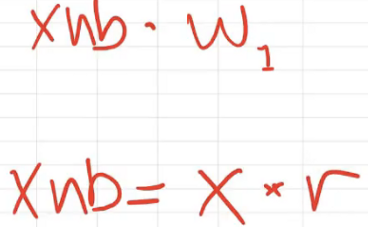 <br> 
**Now here is an important topic** <br> 
By doing this mathematically it doesn't change anything as we could get `x*w*r` by `x*w`, where **"w"** would estimate the **"r"** bit and give us the same output. So this ought to mean that the change that we made to the independent variable should not have made any difference because we can calculate exactly the same thing without making that change. However, there is a marked improvement in result. ***WHY???????*** <br> 
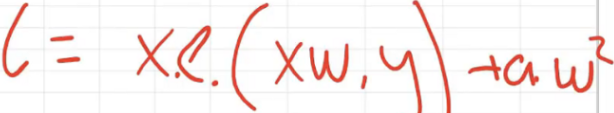 <br> 
Looking at the loss function above, if your weights are large, then the penalty(aw²) gets bigger, and it drowns out the cross entropy piece ***(x.e.(xw, y)). But that’s actually the piece we care about. We actually want it to be a good fit. So we want to have as little regularization going on as we can get away with, which means that we want weights as close to 0 as possible***  What we had before is only $w^2$ in the loss function while we were regularising. But by adding **r(prior)** we are saying that ***all the features have different levels of importance and positive/negative features might be represented in this way***. By doing this we are asking the algo to only penalise the input(already multiplied by r), which are very different from the **prior**. **Difference here is that we are penalising coefficients only when different from the priors instead of penalising coefficients that are $\neq{0}$**. <br>
***We can imbue other ML models with this kind of Bayesian sense by starting out incorporating our theoretical expectations into the data that we give our model. And when we do so, that then means we don’t have to regularize as much.*** <br> 
If we regularise more, it really hurts our accuracy because now it’s trying really hard to get those weights down, the loss function is overwhelmed by the need to reduce the weights. And the need to make it predictive now seems totally unimportant. So by starting out and saying don’t push the weights down so that you end up ignoring the terms, **but instead push them down so that you try to get rid of ones that ignore differences from our expectation based on the Naive Bayes formulation**.<br><br>
The most important sentence in this entire paragraph is: ***we are penalising coefficients that are different from our priors(non-negative) and not penalising coefficients which are $\neq{0}$***. 

In [36]:
x_nb = x.multiply(r) # extremely important line for which the entire section above has been dedicated 
m = LogisticRegression(dual=True, C=0.1)
m.fit(x_nb, y);

val_x_nb = val_x.multiply(r)
preds = m.predict(val_x_nb)
(preds.T==val_y).mean()

0.91768

## fastai NBSVM++

In [8]:
sl=2000

In [9]:
# Here is how we get a model from a bag of words
md = TextClassifierData.from_bow(trn_term_doc, trn_y, val_term_doc, val_y, sl)

In [14]:
learner = md.dotprod_nb_learner()
learner.fit(0.02, 1, wds=1e-6, cycle_len=1)

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.16460011282337467 [0.21208]  0.88088   


[array([0.21208]), 0.88088]

In [ ]:
learner.fit(0.02, 2, wds=1e-6, cycle_len=1)

A Jupyter Widget

[ 0.       0.02014  0.11387  0.92012]                         
[ 1.       0.01275  0.11149  0.92124]                         



In [ ]:
learner.fit(0.02, 2, wds=1e-6, cycle_len=1)

A Jupyter Widget

[ 0.       0.01681  0.11089  0.92129]                           
[ 1.       0.00949  0.10951  0.92223]                          



## References

* Baselines and Bigrams: Simple, Good Sentiment and Topic Classification. Sida Wang and Christopher D. Manning [pdf](https://www.aclweb.org/anthology/P12-2018)